# Library Import

In [1]:
#-- Basics Library
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import os 
from sklearn.preprocessing import MinMaxScaler


#-- Metrics Calculation
from sklearn.metrics import mean_absolute_error as MAE
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import r2_score as R2
from sklearn.metrics import mean_absolute_percentage_error as MAPE


#-- Tensor Flow (NN and Deep Learning)
from tensorflow.keras import models, layers, losses, optimizers, activations, metrics, regularizers, callbacks, utils, initializers
import tensorflow as tf

#-- Warnings OFF
from warnings import simplefilter



simplefilter("ignore", FutureWarning)
np.seterr(all="ignore")
os.environ['KERAS_BACKEND'] = 'theano'
os.environ['PYTHONHASHSEED']=str('123')


%matplotlib inline

# Function definition

In [20]:
def vec_bootstrap(main_df,scaler,X,y,lag_list,pred_list,split_esc,sample=5):
  metrics_list = []

  for i in range(sample):

    model_temp = MLP(look_back=12,vec_num=12)

    model_temp.fit(X_train, y_train,
                epochs=1000,
                batch_size=batch_size,
                verbose=0,
                validation_data = (X_train, y_train),
                shuffle=True)
    
    df_vec = main_df[['date']].copy()
    df_vec['real'] = scaler.inverse_transform(vec_2_esc(y))
    df_vec['pred'] = scaler.inverse_transform(vec_2_esc(pd.DataFrame(model_temp.predict(X,verbose=0))))
    df_vec['tipo'] = ['Treino' if i < split_esc else 'Teste' for i in df_vec.index]
    
    test = df_vec[df_vec.tipo == 'Teste']
    train = df_vec[df_vec.tipo == 'Treino']

    metric_df_final = pd.DataFrame(
      {
      'sample':[i,i],
      'tipo':['Treino','Teste'],
      'MSE': [MSE(train['real'],train['pred']), MSE(test['real'],test['pred'])],
      'MAE': [MAE(train['real'],train['pred']), MAE(test['real'],test['pred'])],
      'MAPE': [MAPE(train['real'],train['pred']), MAPE(test['real'],test['pred'])],
      'R2':  [R2(train['real'],train['pred']), R2(test['real'],test['pred'])],
      }
    )

    metrics_list.append(metric_df_final.copy())
    teste = pd.concat(metrics_list)
    teste.to_csv('teste.csv',index=False)
    print(i)

  return metrics_list
    

In [2]:
def vec_2_esc(df):
  temp_list = []
  for i in range(df.shape[0]):
    obj_slice = df.iloc[i,:].to_list()
    for val in obj_slice:
      temp_list.append(val)

  return pd.DataFrame(temp_list)

In [3]:
def df_transform(path, name):
  '''
    O conjunto de dados em relação aos rios é composto por duas séries
    históricas, cada uma representa a vazão média em [m^3/ s] de um
    determinado mês das usinas hidroelétricas de Furnas e Camargos. Estas
    séries históricas apresentam alta correlação que pode ser explicada pelo
    fato de que ambas as usinas estão situadas no Rio Grande, na bacia do
    Rio Paraná. Os dados são de 82 anos do histórico de operação dessas duas
    usinas hidroelétricas, totalizando 984 amostras mensais desde janeiro de
    1931 até dezembro de 2012, adquiridos pela ONS (Operador Nacional do
    Sistema Elétrico).
  '''

  ## Sequence list of data
  #/content/drive/MyDrive/Colab Notebooks/Tese Mestrado/Rio 01 Camargos.txt
  #/content/drive/MyDrive/Colab Notebooks/Tese Mestrado/Rio 02 Furnas.txt

  df = pd.read_csv(path,sep='\t',header=None)
  df.columns = ['01','02','03',
                '04','05','06',
                '07','08','09',
                '10','11','12']
  df_melted = pd.melt(df)
  

  lista_aux = []
  for i in df_melted.variable.unique():
    for year in range(1931,2013):
      lista_aux.append(year)

  df_melted['year'] = lista_aux
  df_melted['date'] = pd.to_datetime(df_melted.variable.astype(str) + '/' + df_melted['year'].astype(str),format='%m/%Y')
  df_melted.sort_values('date',inplace=True)
  df_melted['name'] = name
  df_melted.reset_index(inplace=True,drop=True)
  
  return df_melted[['date','value','name']]


In [4]:
# Create NN model
def MLP(look_back,vec_num=1):
    
    entrada = layers.Input(shape=look_back)
    estimativa = layers.Dense(24, activation=activations.relu,kernel_initializer=initializers.LecunNormal())(entrada)
    estimativa = layers.Dense(12, activation=activations.relu,kernel_initializer=initializers.LecunNormal())(estimativa)
    estimativa = layers.Dense(12, activation=activations.relu,kernel_initializer=initializers.LecunNormal())(estimativa)
    estimativa = layers.Dense(6, activation=activations.relu,kernel_initializer=initializers.LecunNormal())(estimativa)
    estimativa = layers.Dense(vec_num, activation=activations.linear,kernel_initializer=initializers.LecunNormal())(estimativa)
  
    model = models.Model(inputs=[entrada], outputs=estimativa)

    model.compile(optimizer=optimizers.Adam(), loss='mse',
                  metrics=['mae','mse','mape'])
    return model

In [5]:
def escalar_narmax_build(df):
  df_temp = df[['date','value_norm']].copy()
  df_temp.columns = ['date','lag_12']
  for i in range(1,look_back + 1):
    df_temp['lag_'+str(12-i)] = df_temp['lag_12'].shift(-i)


  df_temp.rename({'lag_0':'pred_1'},inplace=True,axis=1)
  df_temp.dropna(how='any',inplace=True,axis=0)
  df_temp.reset_index(drop=True,inplace=True)

  df_temp['date'] = df['date'].tail(df_temp.shape[0]).to_list()
                
  return df_temp 

In [6]:
def vetorial_narmax_build(df):
  df_temp = df[['date','value_norm']].copy()
  df_temp.columns = ['date','lag_12']
  aux = []
  split_list = [x for x in range(0,df_temp.shape[0] + 1,look_back)]
  for i in range(1,len(split_list)):
    final = split_list[i]
    inicio = split_list[i-1]
    aux.append(df_temp['lag_12'].iloc[inicio:final].to_list())
    
  aux_df = pd.DataFrame(aux) 
  aux_df.columns = ['lag_'+str(x) for x in range(12,0,-1)]

  for i in range(1,len(aux_df.columns)+1):
    aux_df['pred_'+str(i)] = aux_df['lag_'+str(13-i)].shift(-1)
                
  aux_df.dropna(how='any', axis=0,inplace=True)

  return aux_df 

In [7]:
# Plot and save loss function from model history
def model_loss(history,method_name):
    plt.figure(figsize=(8,4))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Test Loss')
    plt.title(f'model loss - {method_name}')
    plt.ylabel('loss')
    plt.xlabel('epochs')
    plt.legend(loc='upper right')
    plt.savefig(f'model_loss_{method_name}.png', format='png')
    plt.show();

In [8]:
def esc_bootstrap(main_df,scaler,X,y,lag_list,pred_list,split_esc,sample=5):
  
  metrics_list = []

  for i in range(sample):

    model_temp = MLP(look_back=12,vec_num=1)

    model_temp.fit(X_train, y_train,
                epochs=250,
                batch_size=batch_size,
                verbose=0,
                validation_data = (X_train, y_train),
                shuffle=True)
    
    df_escalar = main_df[['date']].copy()
    df_escalar['real'] = scaler.inverse_transform(y)
    df_escalar['pred'] = scaler.inverse_transform(model_temp.predict(X, verbose=0))
    df_escalar['tipo'] = ['Treino' if i < split_esc else 'Teste' for i in df_escalar.index]
    df_escalar.to_csv('camargos_pred_results.csv',index=False)

    test = df_escalar[df_escalar.tipo == 'Teste']
    train = df_escalar[df_escalar.tipo == 'Treino']


    metric_df_final = pd.DataFrame(
        {
        'sample': [i,i],
        'tipo':['Treino','Teste'],
        'MSE': [MSE(train['real'],train['pred']), MSE(test['real'],test['pred'])],
        'MAE': [MAE(train['real'],train['pred']), MAE(test['real'],test['pred'])],
        'MAPE': [MAPE(train['real'],train['pred']), MAPE(test['real'],test['pred'])],
        'R2':  [R2(train['real'],train['pred']), R2(test['real'],test['pred'])],
        }
    )

    metrics_list.append(metric_df_final.copy())
    teste = pd.concat(metrics_list)
    teste.to_csv('teste.csv',index=False)
    print(i)

  return metrics_list

In [9]:
#-- Parameters
look_back = 12
num_month = 12
vec_num = 12

#-- Training and fitting
test_size = 12*10
epochs=1000
batch_size= 120

# Camargos

In [ ]:
camargos_raw = df_transform('/content/drive/MyDrive/Colab Notebooks/Tese Mestrado/Rio 01 Camargos.txt',
                        'Camargos')

camargos_scaler = MinMaxScaler()
camargos_raw['value_norm'] = camargos_scaler.fit_transform(camargos_raw[['value']])

In [ ]:
esc_camargos = escalar_narmax_build(camargos_raw)
vec_camargos = vetorial_narmax_build(camargos_raw)

In [ ]:
model_esc = MLP(look_back,vec_num=1)
model_vec = MLP(look_back,vec_num=12)


## Escalar 

In [ ]:
lag_list = [x for x in esc_camargos.columns if 'lag' in x]
pred_list = ['pred_1']

In [ ]:
X = esc_camargos[lag_list].copy()
y = esc_camargos[pred_list].copy()

split_esc = esc_camargos.shape[0] - 12*10
split_vec = vec_camargos.shape[0] - 10

X_train, X_test = X.iloc[:split_esc,:],X.iloc[split_esc:,:]
y_train, y_test = y.iloc[:split_esc,:],y.iloc[split_esc:,:]


In [ ]:
# filePath = "/content/esc_weights_narmax.hdf5"
# model_checkpoint_callback = callbacks.ModelCheckpoint(
#       filepath=filePath,
#       save_weights_only=True,
#       monitor='val_mse',
#       mode='min',
#       save_best_only = True
#       )



model_esc.fit(X_train, y_train,
              epochs=100,
              batch_size=batch_size,
              verbose=0,
              validation_data = (X_train, y_train),
              #callbacks=[model_checkpoint_callback],
              shuffle=True)
  



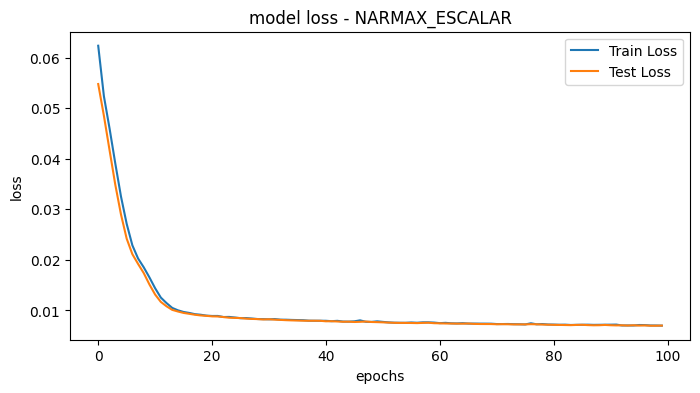

In [ ]:

model_loss(model_esc.history,method_name='NARMAX_ESCALAR')
#model_esc.load_weights(filePath)

In [ ]:

df_escalar = esc_camargos[['date']].copy()
df_escalar['real'] = camargos_scaler.inverse_transform(y)
df_escalar['pred'] = camargos_scaler.inverse_transform(model_esc.predict(X))
df_escalar['tipo'] = ['Treino' if i < split_esc else 'Teste' for i in df_escalar.index]
#df_escalar.to_csv('camargos_pred_results.csv',index=False)

31/31 [==============================] - 0s 3ms/step


,tipo,MSE,MAE,MAPE,R2
0,Treino,2056.808248,27.830372,0.196298,0.705579
1,Teste,2073.453684,28.647776,0.209218,0.699742


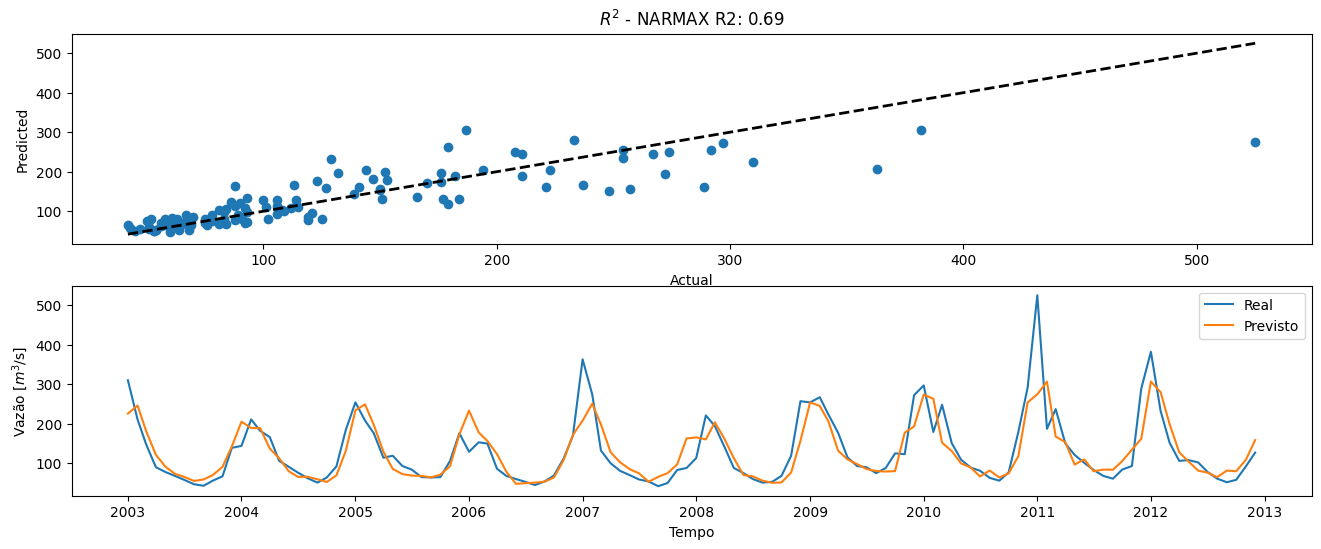

In [ ]:
test = df_escalar[df_escalar.tipo == 'Teste']
train = df_escalar[df_escalar.tipo == 'Treino']

metric_df_final = pd.DataFrame(
      {
      'tipo':['Treino','Teste'],
      'MSE': [MSE(train['real'],train['pred']), MSE(test['real'],test['pred'])],
      'MAE': [MAE(train['real'],train['pred']), MAE(test['real'],test['pred'])],
      'MAPE': [MAPE(train['real'],train['pred']), MAPE(test['real'],test['pred'])],
      'R2':  [R2(train['real'],train['pred']), R2(test['real'],test['pred'])],
      }
  )
display(metric_df_final)
#metric_df_final.to_csv('camargos_metrics.csv' , index=False)

figure, axes = plt.subplots(2, 1, figsize=(16,6))
#figure.suptitle(f'R2 Plot - Scalar problem')

r2_result = metric_df_final[metric_df_final.tipo == 'Teste']['R2'].to_list()[0]

min = test['real'].min()
max = test['real'].max()
axes[0].set_title(f'$R^2$ - NARMAX R2: {r2_result:.2f}') #r2_result:.3f}')
axes[0].scatter(test['real'], test['pred'])
axes[0].plot([min, max], [min, max], 'k--', lw=2)
axes[0].set_xlabel('Actual')
axes[0].set_ylabel('Predicted')


sns.lineplot(ax = axes[1], data=df_escalar.tail(test_size),x='date',y='real', label='Real')
sns.lineplot(ax = axes[1], data=df_escalar.tail(test_size),x='date',y='pred', label='Previsto')
axes[1].set_xlabel('Tempo')
axes[1].set_ylabel('Vazão [$m^3$/s]')

plt.savefig(f'Camargos Escalar results.png', format='png')

plt.show()

In [ ]:
aow = esc_bootstrap(esc_camargos,camargos_scaler,X,y,lag_list,pred_list,split_esc,sample=100)

In [ ]:
teste = pd.concat(aow)
teste.to_csv('teste.csv',index=False)

## Vetorial

In [ ]:
vec_camargos.shape

(81, 24)

In [ ]:
lag_list = [x for x in vec_camargos.columns if 'lag' in x]
pred_list = [x for x in vec_camargos.columns if 'pred' in x]

X = vec_camargos[lag_list].copy()
y = vec_camargos[pred_list].copy()

X_train, X_test = X.iloc[:split_vec,:],X.iloc[split_vec:,:]
y_train, y_test = y.iloc[:split_vec,:],y.iloc[split_vec:,:]

In [ ]:


# filePath = "/content/camargos_vec_weights_narmax.hdf5"
# model_checkpoint_callback = callbacks.ModelCheckpoint(
#       filepath=filePath,
#       save_weights_only=True,
#       monitor='val_mse',
#       mode='min',
#       save_best_only = True
#       )


model_vec.fit(X_train, y_train,
              epochs=2500,
              batch_size=batch_size,
              verbose=1,
              validation_data = (X_train, y_train),
#              callbacks=[model_checkpoint_callback],
              shuffle=True)


A saída de streaming foi truncada nas últimas 5000 linhas.
1/1 [==============================] - 0s 44ms/step - loss: 0.0042 - mae: 0.0439 - mse: 0.0042 - mape: 20491.1816 - val_loss: 0.0042 - val_mae: 0.0439 - val_mse: 0.0042 - val_mape: 20577.6875
Epoch 2/2500
1/1 [==============================] - 0s 58ms/step - loss: 0.0042 - mae: 0.0439 - mse: 0.0042 - mape: 20577.6875 - val_loss: 0.0042 - val_mae: 0.0438 - val_mse: 0.0042 - val_mape: 20708.9004
Epoch 3/2500
1/1 [==============================] - 0s 61ms/step - loss: 0.0042 - mae: 0.0438 - mse: 0.0042 - mape: 20708.9023 - val_loss: 0.0042 - val_mae: 0.0438 - val_mse: 0.0042 - val_mape: 20865.0078
Epoch 4/2500
1/1 [==============================] - 0s 58ms/step - loss: 0.0042 - mae: 0.0438 - mse: 0.0042 - mape: 20865.0059 - val_loss: 0.0042 - val_mae: 0.0439 - val_mse: 0.0042 - val_mape: 20897.5527
Epoch 5/2500
1/1 [==============================] - 0s 61ms/step - loss: 0.0042 - mae: 0.0439 - mse: 0.0042 - mape: 20897.5527 - val_l

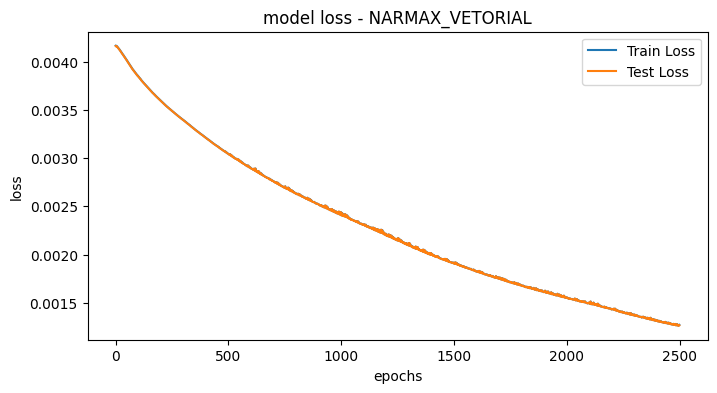

In [ ]:

#model_loss(model_vec.history,method_name='NARMAX_VETORIAL')
#model_vec.load_weights(filePath)

In [ ]:

df_vec = esc_camargos[['date']].copy()
df_vec['real'] = camargos_scaler.inverse_transform(vec_2_esc(y))
df_vec['pred'] = camargos_scaler.inverse_transform(vec_2_esc(pd.DataFrame(model_vec.predict(X))))
df_vec['tipo'] = ['Treino' if i < split_esc else 'Teste' for i in df_vec.index]
#df_vec.to_csv('camargos_pred_results_vec.csv',index=False)


31/31 [==============================] - 0s 2ms/step


ValueError: ignored

,tipo,MSE,MAE,MAPE,R2
0,Treino,1223.724007,23.805278,0.186820,0.824831
1,Teste,2671.649667,34.787064,0.258938,0.613117


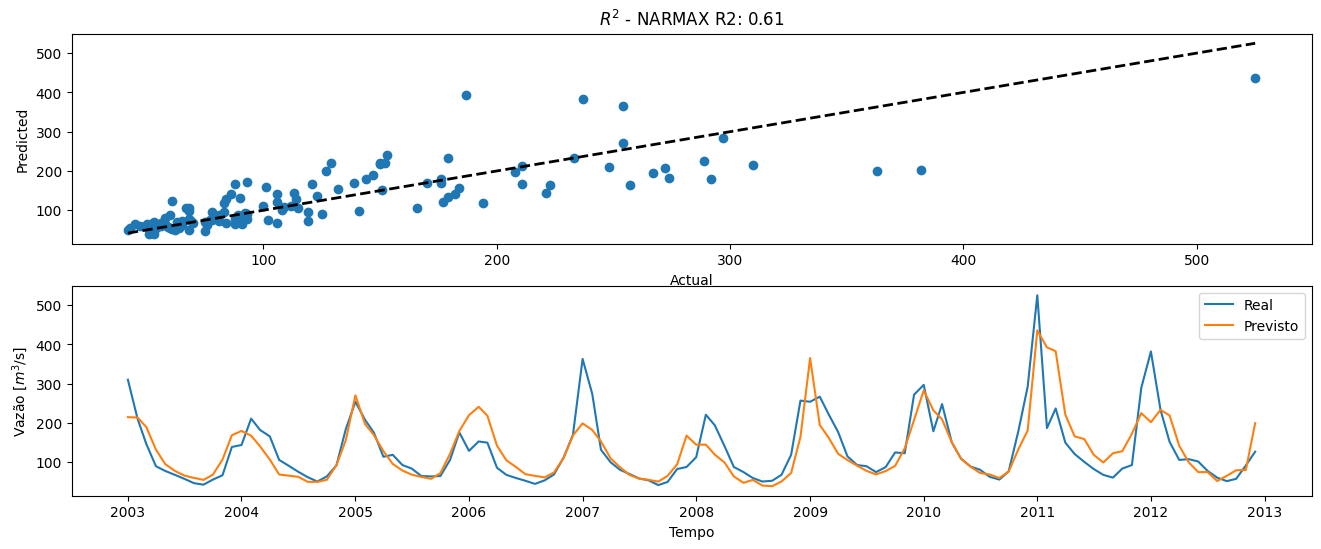

In [ ]:

test = df_vec[df_vec.tipo == 'Teste']
train = df_vec[df_vec.tipo == 'Treino']

metric_df_final = pd.DataFrame(
      {
      'tipo':['Treino','Teste'],
      'MSE': [MSE(train['real'],train['pred']), MSE(test['real'],test['pred'])],
      'MAE': [MAE(train['real'],train['pred']), MAE(test['real'],test['pred'])],
      'MAPE': [MAPE(train['real'],train['pred']), MAPE(test['real'],test['pred'])],
      'R2':  [R2(train['real'],train['pred']), R2(test['real'],test['pred'])],
      }
  )
display(metric_df_final)
#metric_df_final.to_csv('camargos_metrics_vec.csv' , index=False)

figure, axes = plt.subplots(2, 1, figsize=(16,6))
#figure.suptitle(f'R2 Plot - Scalar problem')

r2_result = metric_df_final[metric_df_final.tipo == 'Teste']['R2'].to_list()[0]

min = test['real'].min()
max = test['real'].max()
axes[0].set_title(f'$R^2$ - NARMAX R2: {r2_result:.2f}') #r2_result:.3f}')
axes[0].scatter(test['real'], test['pred'])
axes[0].plot([min, max], [min, max], 'k--', lw=2)
axes[0].set_xlabel('Actual')
axes[0].set_ylabel('Predicted')


sns.lineplot(ax = axes[1], data=df_vec.tail(test_size),x='date',y='real', label='Real')
sns.lineplot(ax = axes[1], data=df_vec.tail(test_size),x='date',y='pred', label='Previsto')
axes[1].set_xlabel('Tempo')
axes[1].set_ylabel('Vazão [$m^3$/s]')

#plt.savefig(f'Camargos Vetorial results NARMAX.png', format='png')

plt.show()

In [ ]:
aow = vec_bootstrap(esc_camargos,camargos_scaler,X,y,lag_list,pred_list,split_esc,sample=100)


71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


In [ ]:

teste = pd.concat(aow).reset_index(drop=True)
teste

,sample,tipo,MSE,MAE,MAPE,R2
0,0,Treino,1533.655629,25.362066,0.193027,0.780466
1,0,Teste,2950.480234,36.534229,0.286224,0.572739
2,1,Treino,1031.984815,22.105400,0.178989,0.852277
3,1,Teste,2825.383558,34.087658,0.262663,0.590854
4,2,Treino,1416.187831,25.391833,0.207300,0.797280
...,...,...,...,...,...,...
195,97,Teste,3056.761569,38.994789,0.329978,0.557348
196,98,Treino,1517.185783,26.457272,0.206765,0.782823
197,98,Teste,3318.924164,38.816399,0.313826,0.519384
198,99,Treino,1376.069063,24.879343,0.193628,0.803023


In [ ]:

teste.to_csv('teste_camargos_vec_bootstrap.csv',index=False)

<Axes: xlabel='R2', ylabel='Count'>

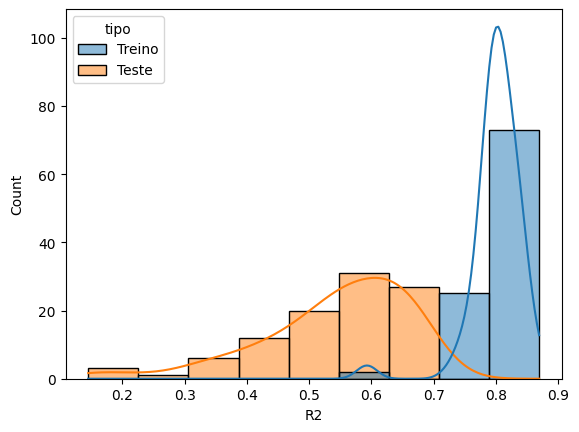

In [ ]:

sns.histplot(data=teste,x='R2',hue='tipo',kde=True)

# Furnas

In [14]:
furnas_raw = df_transform('/content/drive/MyDrive/Colab Notebooks/Tese Mestrado/Rio 02 Furnas.txt',
                        'Furnas')

furnas_scaler = MinMaxScaler()
furnas_raw['value_norm'] = furnas_scaler.fit_transform(furnas_raw[['value']])

In [15]:
esc_furnas = escalar_narmax_build(furnas_raw)
vec_furnas = vetorial_narmax_build(furnas_raw)

In [16]:
model_esc = MLP(look_back,vec_num=1)
model_vec = MLP(look_back,vec_num=12)


## Escalar 

In [ ]:
lag_list = [x for x in esc_furnas.columns if 'lag' in x]
pred_list = ['pred_1']

In [ ]:
X = esc_furnas[lag_list].copy()
y = esc_furnas[pred_list].copy()

split_esc = esc_furnas.shape[0] - 12*10
split_vec = vec_furnas.shape[0] - 10

X_train, X_test = X.iloc[:split_esc,:],X.iloc[split_esc:,:]
y_train, y_test = y.iloc[:split_esc,:],y.iloc[split_esc:,:]


In [ ]:
# filePath = "/content/furnas_esc_weights_narmax.hdf5"
# model_checkpoint_callback = callbacks.ModelCheckpoint(
#       filepath=filePath,
#       save_weights_only=True,
#       monitor='val_mse',
#       mode='min',
#       save_best_only = True
#       )



model_esc.fit(X_train, y_train,
              epochs=1000,
              batch_size=batch_size,
              verbose=1,
              validation_data = (X_train, y_train),
              #callbacks=[model_checkpoint_callback],
              shuffle=True)
  



In [ ]:
model_loss(model_esc.history,method_name='NARMAX_ESCALAR')
#model_esc.load_weights(filePath)

In [ ]:

df_escalar = esc_furnas[['date']].copy()
df_escalar['real'] = furnas_scaler.inverse_transform(y)
df_escalar['pred'] = furnas_scaler.inverse_transform(model_esc.predict(X))
df_escalar['tipo'] = ['Treino' if i < split_esc else 'Teste' for i in df_escalar.index]
#df_escalar.to_csv('furnas_pred_results.csv',index=False)

In [ ]:
test = df_escalar[df_escalar.tipo == 'Teste']
train = df_escalar[df_escalar.tipo == 'Treino']

metric_df_final = pd.DataFrame(
      {
      'tipo':['Treino','Teste'],
      'MSE': [MSE(train['real'],train['pred']), MSE(test['real'],test['pred'])],
      'MAE': [MAE(train['real'],train['pred']), MAE(test['real'],test['pred'])],
      'MAPE': [MAPE(train['real'],train['pred']), MAPE(test['real'],test['pred'])],
      'R2':  [R2(train['real'],train['pred']), R2(test['real'],test['pred'])],
      }
  )
display(metric_df_final)
#metric_df_final.to_csv('furnas_metrics.csv' , index=False)

figure, axes = plt.subplots(2, 1, figsize=(16,6))
#figure.suptitle(f'R2 Plot - Scalar problem')

r2_result = metric_df_final[metric_df_final.tipo == 'Teste']['R2'].to_list()[0]

min = test['real'].min()
max = test['real'].max()
axes[0].set_title(f'$R^2$ - NARMAX R2: {r2_result:.2f}') #r2_result:.3f}')
axes[0].scatter(test['real'], test['pred'])
axes[0].plot([min, max], [min, max], 'k--', lw=2)
axes[0].set_xlabel('Actual')
axes[0].set_ylabel('Predicted')


sns.lineplot(ax = axes[1], data=df_escalar.tail(test_size),x='date',y='real', label='Real')
sns.lineplot(ax = axes[1], data=df_escalar.tail(test_size),x='date',y='pred', label='Previsto')
axes[1].set_xlabel('Tempo')
axes[1].set_ylabel('Vazão [$m^3$/s]')

plt.savefig(f'Furnas Escalar results.png', format='png')

plt.show()

In [ ]:
aow = esc_bootstrap(esc_furnas,furnas_scaler,X,y,lag_list,pred_list,split_esc,sample=100)

In [ ]:
teste = pd.concat(aow)
teste.to_csv('teste_furnas_esc.csv',index=False)

In [ ]:
sns.histplot(data=teste, x='R2',hue='tipo')

## Vetorial

Epoch 1/10
1/1 [==============================] - 2s 2s/step - loss: 0.0758 - mae: 0.2120 - mse: 0.0758 - mape: 4865.7568 - val_loss: 0.0746 - val_mae: 0.2093 - val_mse: 0.0746 - val_mape: 718.9055
Epoch 2/10
1/1 [==============================] - 0s 60ms/step - loss: 0.0746 - mae: 0.2093 - mse: 0.0746 - mape: 718.9055 - val_loss: 0.0735 - val_mae: 0.2068 - val_mse: 0.0735 - val_mape: 2496.9724
Epoch 3/10
1/1 [==============================] - 0s 84ms/step - loss: 0.0735 - mae: 0.2068 - mse: 0.0735 - mape: 2496.9724 - val_loss: 0.0724 - val_mae: 0.2044 - val_mse: 0.0724 - val_mape: 4191.7671
Epoch 4/10
1/1 [==============================] - 0s 88ms/step - loss: 0.0724 - mae: 0.2044 - mse: 0.0724 - mape: 4191.7671 - val_loss: 0.0715 - val_mae: 0.2021 - val_mse: 0.0715 - val_mape: 5776.4590
Epoch 5/10
1/1 [==============================] - 0s 60ms/step - loss: 0.0715 - mae: 0.2021 - mse: 0.0715 - mape: 5776.4580 - val_loss: 0.0706 - val_mae: 0.1999 - val_mse: 0.0706 - val_mape: 7317.6040

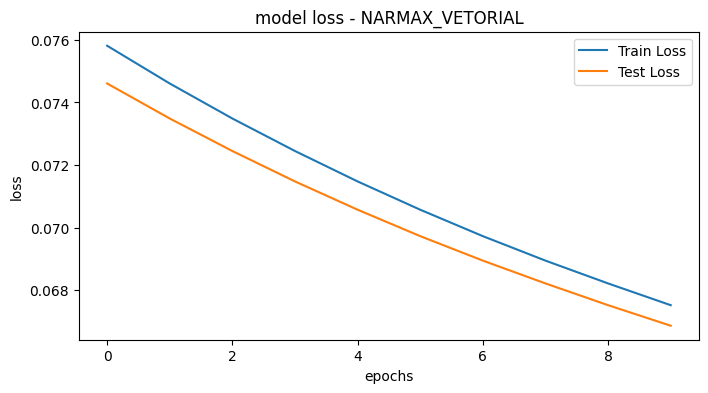

3/3 [==============================] - 0s 3ms/step


,tipo,MSE,MAE,MAPE,R2
0,Treino,84588.260421,201.239078,0.231739,0.775144
1,Teste,162763.521256,274.031427,0.321018,0.565097


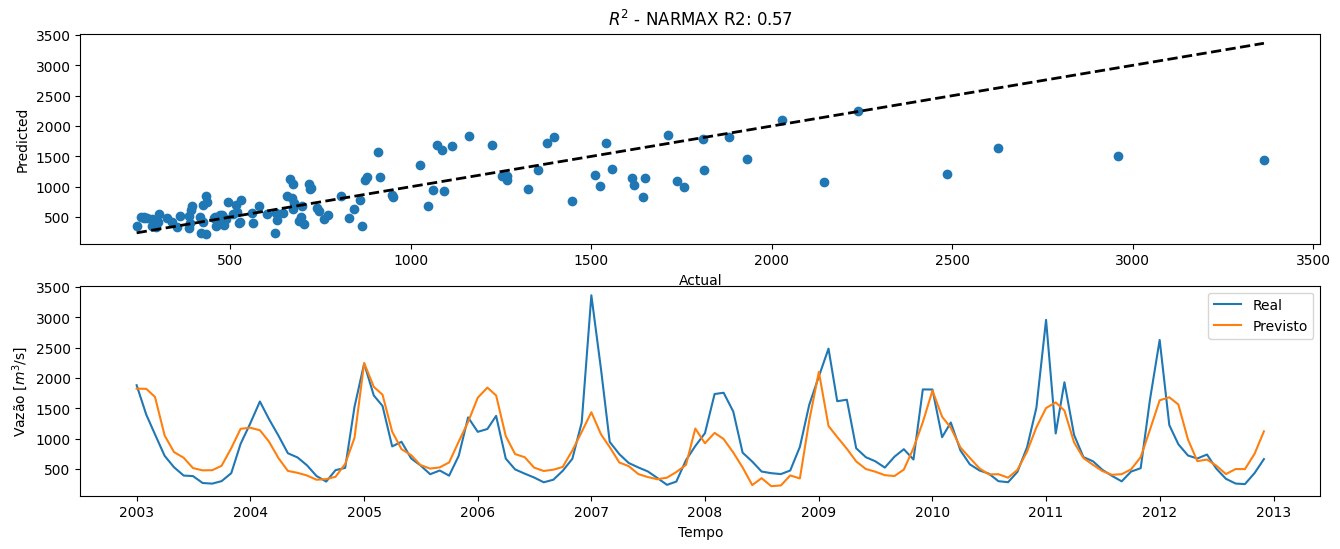

In [ ]:
lag_list = [x for x in vec_furnas.columns if 'lag' in x]
pred_list = [x for x in vec_furnas.columns if 'pred' in x]

X = vec_furnas[lag_list].copy()
y = vec_furnas[pred_list].copy()

split_esc = esc_camargos.shape[0] - 12*10
split_vec = vec_camargos.shape[0] - 10

X_train, X_test = X.iloc[:split_vec,:],X.iloc[split_vec:,:]
y_train, y_test = y.iloc[:split_vec,:],y.iloc[split_vec:,:]

# filePath = "/content/furnas_vec_weights_narmax.hdf5"
# model_checkpoint_callback = callbacks.ModelCheckpoint(
#       filepath=filePath,
#       save_weights_only=True,
#       monitor='val_mse',
#       mode='min',
#       save_best_only = True
#       )


model_vec.fit(X_train, y_train,
              epochs=10,
              batch_size=batch_size,
              verbose=1,
              validation_data = (X_train, y_train),
              #callbacks=[model_checkpoint_callback],
              shuffle=True)


model_loss(model_vec.history,method_name='NARMAX_VETORIAL')
model_vec.load_weights(filePath)

df_vec = esc_furnas[['date']].copy()
df_vec['real'] = furnas_scaler.inverse_transform(vec_2_esc(y))
df_vec['pred'] = furnas_scaler.inverse_transform(vec_2_esc(pd.DataFrame(model_vec.predict(X))))
df_vec['tipo'] = ['Treino' if i < split_esc else 'Teste' for i in df_vec.index]
df_vec.to_csv('furnas_pred_results_vec.csv',index=False)


test = df_vec[df_vec.tipo == 'Teste']
train = df_vec[df_vec.tipo == 'Treino']

metric_df_final = pd.DataFrame(
      {
      'tipo':['Treino','Teste'],
      'MSE': [MSE(train['real'],train['pred']), MSE(test['real'],test['pred'])],
      'MAE': [MAE(train['real'],train['pred']), MAE(test['real'],test['pred'])],
      'MAPE': [MAPE(train['real'],train['pred']), MAPE(test['real'],test['pred'])],
      'R2':  [R2(train['real'],train['pred']), R2(test['real'],test['pred'])],
      }
  )
display(metric_df_final)
metric_df_final.to_csv('furnas_metrics_vec.csv' , index=False)

figure, axes = plt.subplots(2, 1, figsize=(16,6))
#figure.suptitle(f'R2 Plot - Scalar problem')

r2_result = metric_df_final[metric_df_final.tipo == 'Teste']['R2'].to_list()[0]

min = test['real'].min()
max = test['real'].max()
axes[0].set_title(f'$R^2$ - NARMAX R2: {r2_result:.2f}') #r2_result:.3f}')
axes[0].scatter(test['real'], test['pred'])
axes[0].plot([min, max], [min, max], 'k--', lw=2)
axes[0].set_xlabel('Actual')
axes[0].set_ylabel('Predicted')


sns.lineplot(ax = axes[1], data=df_vec.tail(test_size),x='date',y='real', label='Real')
sns.lineplot(ax = axes[1], data=df_vec.tail(test_size),x='date',y='pred', label='Previsto')
axes[1].set_xlabel('Tempo')
axes[1].set_ylabel('Vazão [$m^3$/s]')

plt.savefig(f'Furnas Vetorial results NARMAX.png', format='png')

plt.show()

In [18]:
lag_list = [x for x in vec_furnas.columns if 'lag' in x]
pred_list = [x for x in vec_furnas.columns if 'pred' in x]

X = vec_furnas[lag_list].copy()
y = vec_furnas[pred_list].copy()

split_esc = esc_furnas.shape[0] - 12*10
split_vec = vec_furnas.shape[0] - 10

X_train, X_test = X.iloc[:split_vec,:],X.iloc[split_vec:,:]
y_train, y_test = y.iloc[:split_vec,:],y.iloc[split_vec:,:]

In [24]:
aow = vec_bootstrap(esc_furnas,furnas_scaler,X,y,lag_list,pred_list,split_esc,sample=100)

71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


<Axes: xlabel='MAE', ylabel='Count'>

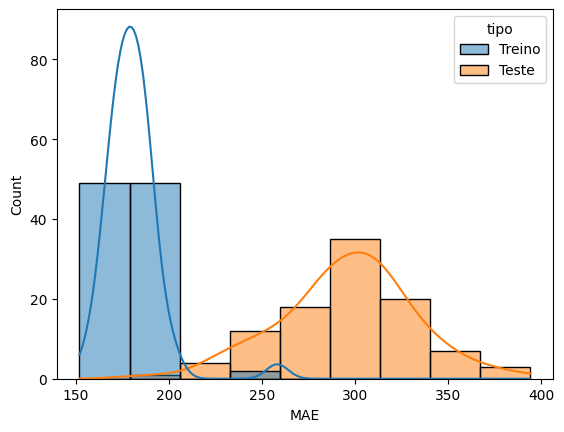

In [26]:


teste = pd.concat(aow).reset_index(drop=True)
teste

teste.to_csv('teste_camargos_vec_bootstrap.csv',index=False)

sns.histplot(data=teste,x='MAE',hue='tipo',kde=True)